In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

import sys
sys.path.append("..")
from meta_stream import MetaStream

In [2]:
df = pd.read_csv("../../data/electricity-normalized.csv")
df = df[['period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']]

In [3]:
# NOTE: list of regression algorithms
models =    [
            SVR(),
            RandomForestRegressor(random_state=42),
            LinearRegression(),
            Ridge(),
            GradientBoostingRegressor(random_state=42),
            DecisionTreeRegressor()
            ]

In [4]:
model_names = {
    type(SVR()).__name__: 'SVR',
    type(RandomForestRegressor()).__name__: 'RF',
    type(LinearRegression()).__name__: 'LR',
    type(Ridge()).__name__: 'RIDGE',
    type(GradientBoostingRegressor()).__name__: 'GBR',
    type(DecisionTreeRegressor()).__name__: 'DTR',
}

Parameter settings for MetaStream (considering a meta-level window size of 200)

In [5]:
base_data_window = 96*2
base_delay_window = 0
base_sel_window_size = 48*2
meta_data_window = 200
threshold = 0.1

In [6]:
pair_list = []
metastream_score = []
default_score = []

In [7]:
meta_learner = RandomForestClassifier()
for pair in combinations(models, 2):
    reg1_name = type(pair[0]).__name__
    reg2_name = type(pair[1]).__name__
    print(f'Regressor pair: {reg1_name}, {reg2_name}')
    
    metas = MetaStream(meta_learner, pair, base_data_window, base_delay_window, base_sel_window_size, meta_data_window, strategy='tie', default=True, ensemble=True, pairs=True, threshold=threshold)
    metas.base_train(data=df, target='nswdemand')
    metas.meta_train(data=df, target='nswdemand')
    
    metas.print_results()
    base, meta = metas.get_results()
    
    pair_list.append(f'{model_names[reg1_name]}/{model_names[reg2_name]}')
    metastream_score.append(meta['recommended'])
    default_score.append(meta['default'])
    
    print('######################################################################')

Regressor pair: SVR, RandomForestRegressor
Mean score Recommended 0.582+-0.600
Meta-level score Recommended 0.644
Mean score default 0.338+-0.373
Meta-level score default 0.219
Mean score ensemble 0.420+-0.429
Mean score reg 1. 0.694
Mean score reg 2. 0.338
######################################################################
Regressor pair: SVR, LinearRegression
Mean score Recommended 0.487+-0.527
Meta-level score Recommended 0.493
Mean score default 0.694+-0.689
Meta-level score default 0.596
Mean score ensemble 0.427+-0.349
Mean score reg 1. 0.694
Mean score reg 2. 0.429
######################################################################
Regressor pair: SVR, Ridge
Mean score Recommended 0.680+-0.611
Meta-level score Recommended 0.600
Mean score default 0.694+-0.689
Meta-level score default 0.459
Mean score ensemble 0.669+-0.687
Mean score reg 1. 0.694
Mean score reg 2. 0.752
######################################################################
Regressor pair: SVR, GradientBoost

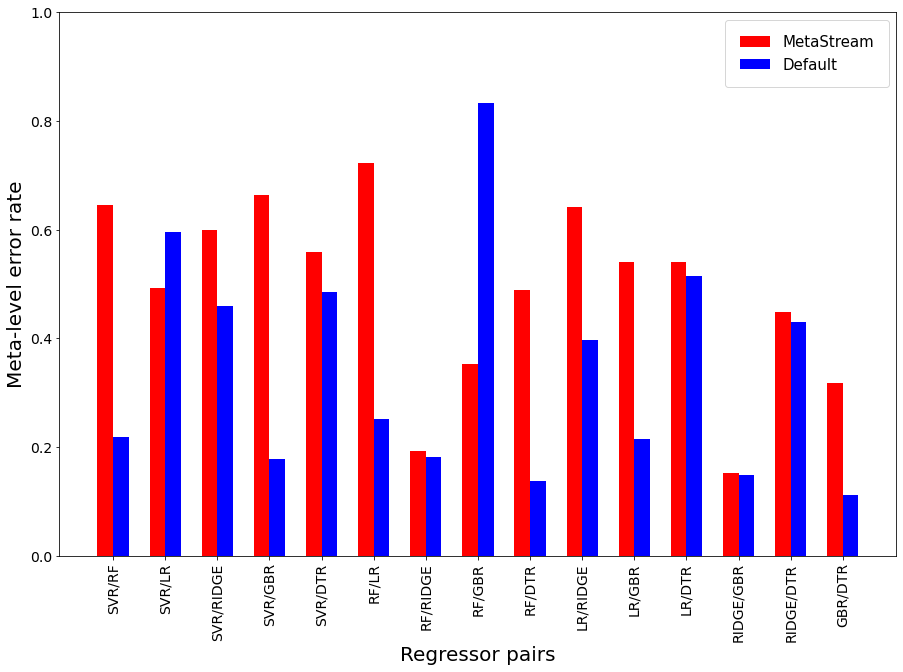

In [8]:
bar_width = 0.3
bar_locs = np.arange(len(pair_list))

plt.figure(figsize=(15,10))
plt.bar(bar_locs, metastream_score, width=bar_width, color='r', label='MetaStream')
plt.bar(bar_locs+bar_width, default_score, width=bar_width, color='b', label='Default')

plt.xticks(bar_locs+bar_width/2, pair_list, fontsize=14, rotation=90)
plt.xlabel('Regressor pairs', fontsize=20)

plt.yticks(fontsize=14)
plt.ylim(0, 1)
plt.ylabel('Meta-level error rate', fontsize=20)

plt.legend(loc='best', borderpad=1, fontsize=15)
plt.show()